In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from collections import Counter
from spam_classifier import Config, Message, NaiveBayesClf, Utils

In [3]:
df = pd.read_csv(Config.data_cleaned_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
 2   is_spam   5572 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 92.6+ KB


In [4]:
values_category = df['Category'].value_counts().reset_index()
values_category.columns = ['Category', 'Count']
values_category

,Category,Count
0,ham,4825
1,spam,747


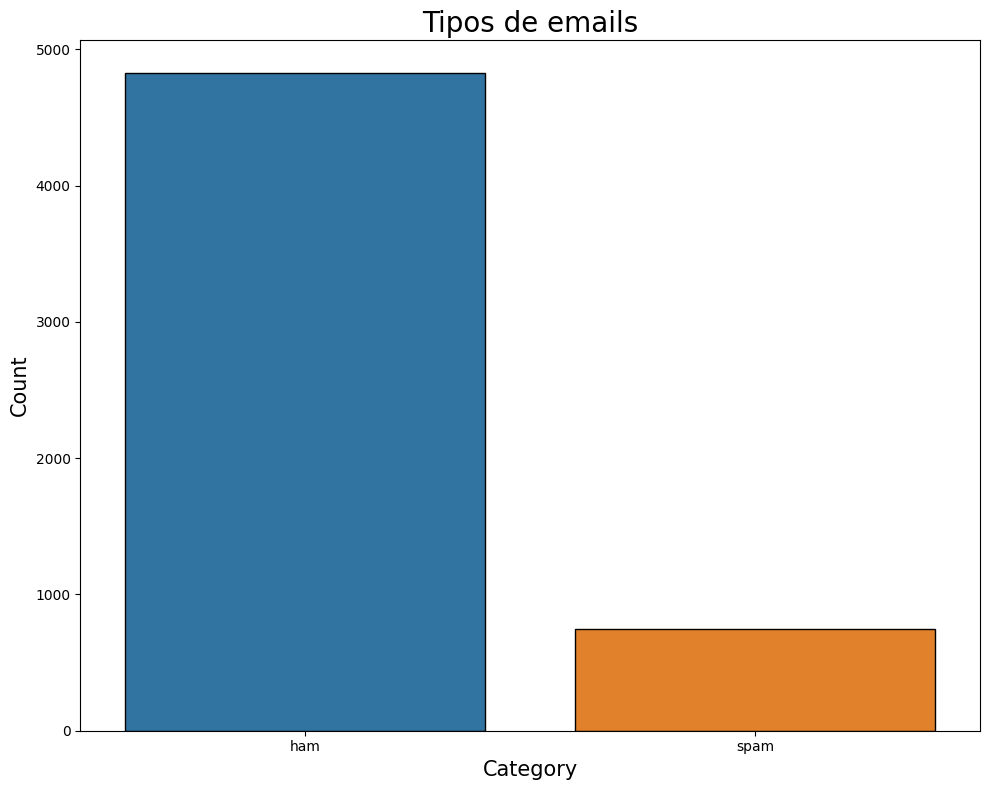

In [5]:
plt.figure(figsize=(10,8))
sns.barplot(data=values_category, 
            x='Category',
            y='Count',
            hue='Category',
            edgecolor = 'black'
            )
plt.title("Tipos de emails", fontsize=20)
plt.xlabel("Category", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.tight_layout()

Gracias a este gráfico de barras, podemos observar que dentro de nuestro dataset hay mayor cantidad de registros de emails que no son spam. Esto nos demuestra un claro sesgo hacia la clase "ham".

In [6]:
messages = [Message(text, is_spam) for text, is_spam in zip(df['Message'], df['is_spam'])]

train_msg, test_msg = Utils().split_data(messages, 0.70)

In [7]:
model = NaiveBayesClf(k=0.8)
model.train(train_msg)

### **Métricas del modelo**

Accuracy: 26.2%

Precision: 15.61%

Recall: 94.96%

F1-Score: 26.81%

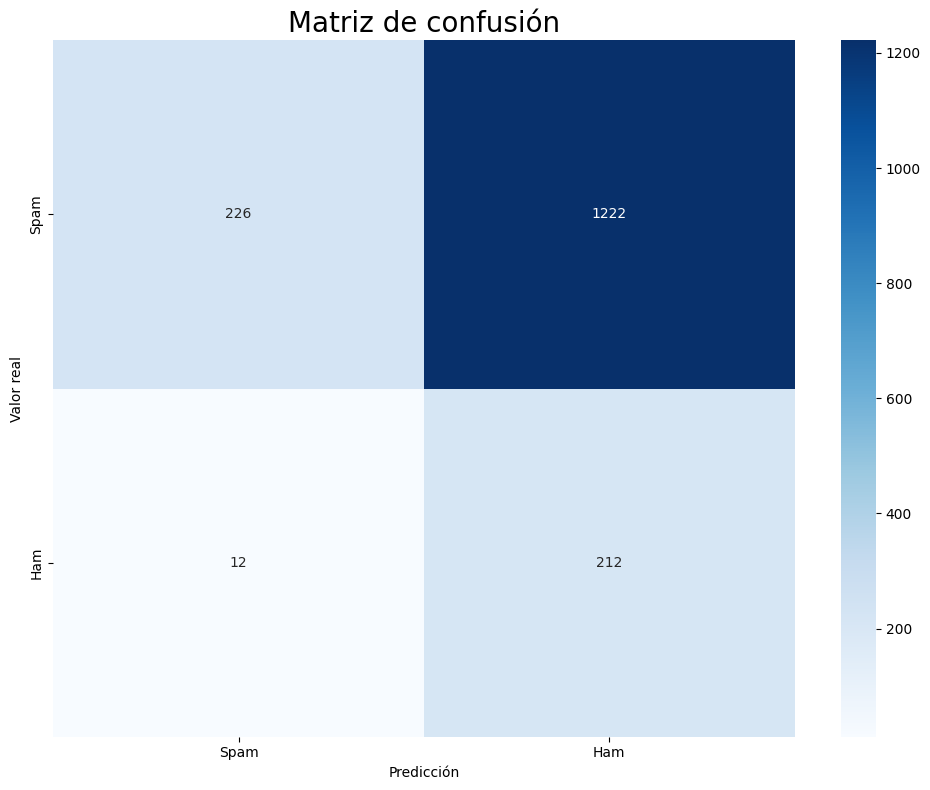

In [8]:
predictions = [(message, model.predict(message.text)) for message in test_msg]
confusion_mat = Counter((message.is_spam, spam_prob > 0.5) for message, spam_prob in predictions)

tp = confusion_mat[(True, True)]
fp = confusion_mat[(False, True)]
fn = confusion_mat[(True, False)]
tn = confusion_mat[(False, False)]

accuracy = Utils().accuracy(tp, fp, fn, tn)
precision = Utils().precision(tp, fp)
recall = Utils().recall(tp, fn)
f1 = Utils().f1_score(tp, fp, fn)

display(Markdown("### **Métricas del modelo**"))
display(Markdown(f"Accuracy: {round(accuracy * 100, 2)}%"))
display(Markdown(f"Precision: {round(precision * 100, 2)}%"))
display(Markdown(f"Recall: {round(recall * 100, 2)}%"))
display(Markdown(f"F1-Score: {round(f1 * 100, 2)}%"))

plt.figure(figsize=(10, 8))
sns.heatmap(data=[[tp, fp], [fn, tn]],
            xticklabels=['Spam', 'Ham'],
            yticklabels=['Spam', 'Ham'],
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title("Matriz de confusión", fontsize=20)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()

**Análisis de las métricas del modelo**
* **Accuracy**: Con un valor del 54.31%, esta métrica nos demuestra que el modelo posee un desempeño general pobre. Esto es debido a que sólo el 54.31% de los casos totales son predicciones correctas.
* **Precision**: Esta métrica, con un valor del 18.4%, indica que una proporción reducida de los casos positivos (TP y FP) son correctamente identificadas. Esto denota que el modelo está identificando que muchos emails contienen spam cuando no es así.
* **Recall**: El recuerdo (76.3%) nos indica que el modelo está prediciendo que un email contiene spam con demasiada frecuencia, esto aumenta la cantidad de casos falsos positivos, es decir, casos en los que el modelo predice que erróneamente que el email contiene spam.
* **F1-Score**: A sabiendas de que esta métrica posee una valor 29.65%, podemos concluir en que el balance entre la precision y el recall es demasiado bajo, lo que denota un desempeño pobre del modelo.

**Análisis de la matriz de confusión**
* **Casos verdaderos positivos** (TP): En este grupo podemos ver que el modelo predijo 161 casos en los que un email verdaderamente era spam. En contraparte con los casos verdaderos negativos, es decir, aquellos email que no poseen spam, se observan menos registros. Esto podría indicar un claro sesgo hacia la clase "ham".
* **Casos falsos positivos** (FP): En esta sección se pueden apreciar demasiadas instancias (714) en las cuales el modelo predijo que un email contenía spam, cuando verdaderamente no lo contenía. Esto es sumamente alarmante si se desea emplear este modelo en un escenario real, ya que etiqueta de manera errónea emails que no contienen spam, lo que llevaría a perder información valiosa.
* **Casos falsos negativos** (FN): Con 50 casos, este grupo es el menor de todos. Tan solo en 50 ocasiones, el modelo clasificó erróneamente emails que verdaderamente contenían spam como emails que no lo hacían. Si comparamos con el grupo de los falsos positivos, podemos ver que hay un decremento importante y esto lo vemos reflejado en el recall. 
* **Casos verdareros negativos** (TN): Siendo el grupo con mayor cantidad de casos, podemos observar que el modelo ha sido capaz de identificar correctamente a emails sin spam en 747 instancias. Esto afirma que existe un claro sesgo hacia esta clase.

In [11]:
words = sorted(model.tokens, key=lambda x: model.prob_spam_given_token(x))
display(Markdown(f"Palabras que aparecen con mayor frecuencia en emails con spam: {words[-10:]}"))
display(Markdown(f"Palabras que aparecen con mayor frecuencia en emails sin spam: {words[:10]}"))

Palabras que aparecen con mayor frecuencia en emails con spam: ['you', 'out', 'after', 'maybe', 'move', 'should', 'it', 'ready', "can't", "i'm"]

Palabras que aparecen con mayor frecuencia en emails sin spam: ['suggest', 'greece', 'still', 'an', 'setting', 'right', 'a', 'the', 'do', 'are']